Script to calculate coverage of realtime total vector product

choose region - USWC|USEGC|USHI|PRVI|AKNS|PW
find data files in path - netCDF or asc?


In [1]:
%matplotlib notebook
import pandas as pd
import xarray as xr
import numpy as np
import os, sys
import netCDF4
import re
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import scipy.ndimage as ndimage
from IPython.display import clear_output
from cartopy import crs,feature

In [2]:
def findCount(file):
# find the count
    cdata = xr.open_dataset(file,drop_variables=["procParams","site_lat","site_lon","site_code","site_netCode"])

    # chunk this for larger data sets
    firstrun=0

    for i in range(0,cdata.u.shape[0],2000):
        end=i+1999
        if (end>cdata.u.shape[0]):
            end=cdata.u.shape[0]
        if firstrun==0:
            totalCount=cdata.u.isel(time=slice(i,end)).count(axis=0)
            firstrun=1
        else:
            totalCount=totalCount+cdata.u.isel(time=slice(i,end)).count(axis=0)
            clear_output(wait=True)
            print(i,totalCount.max())

    # grid
    x,y=np.meshgrid(totalCount.lon.values,totalCount.lat.values)
    # mask out 0s
    mask=totalCount==0
    # Clean up with gaussian filter
    Z2 = ndimage.gaussian_filter(totalCount.values,sigma=1)

    # calculate percent coverage from count|
    percentCoverage_smooth=np.ceil((Z2/cdata.time.size)*100)
    percentCoverage=np.ceil((totalCount.values/cdata.time.size)*100)

    # find the points where the count is greater than 1
    tc=totalCount.to_dataframe()
    goodGrid=tc[tc.u>1].reset_index() 

    return(percentCoverage,percentCoverage_smooth,goodGrid,x,y,mask)


In [3]:
# this uses a nc file concatenated by ncrcat
file='/Users/tom/Desktop/HFRnet_Coverage/USWC-RTV.nc'
(USWC_PC,USWC_PC_smooth,USWCgrid,USWC_x,USWC_y,USWC_mask)=findCount(file)

106000 <xarray.DataArray 'u' ()>
array(106491)


<IPython.core.display.Javascript object>


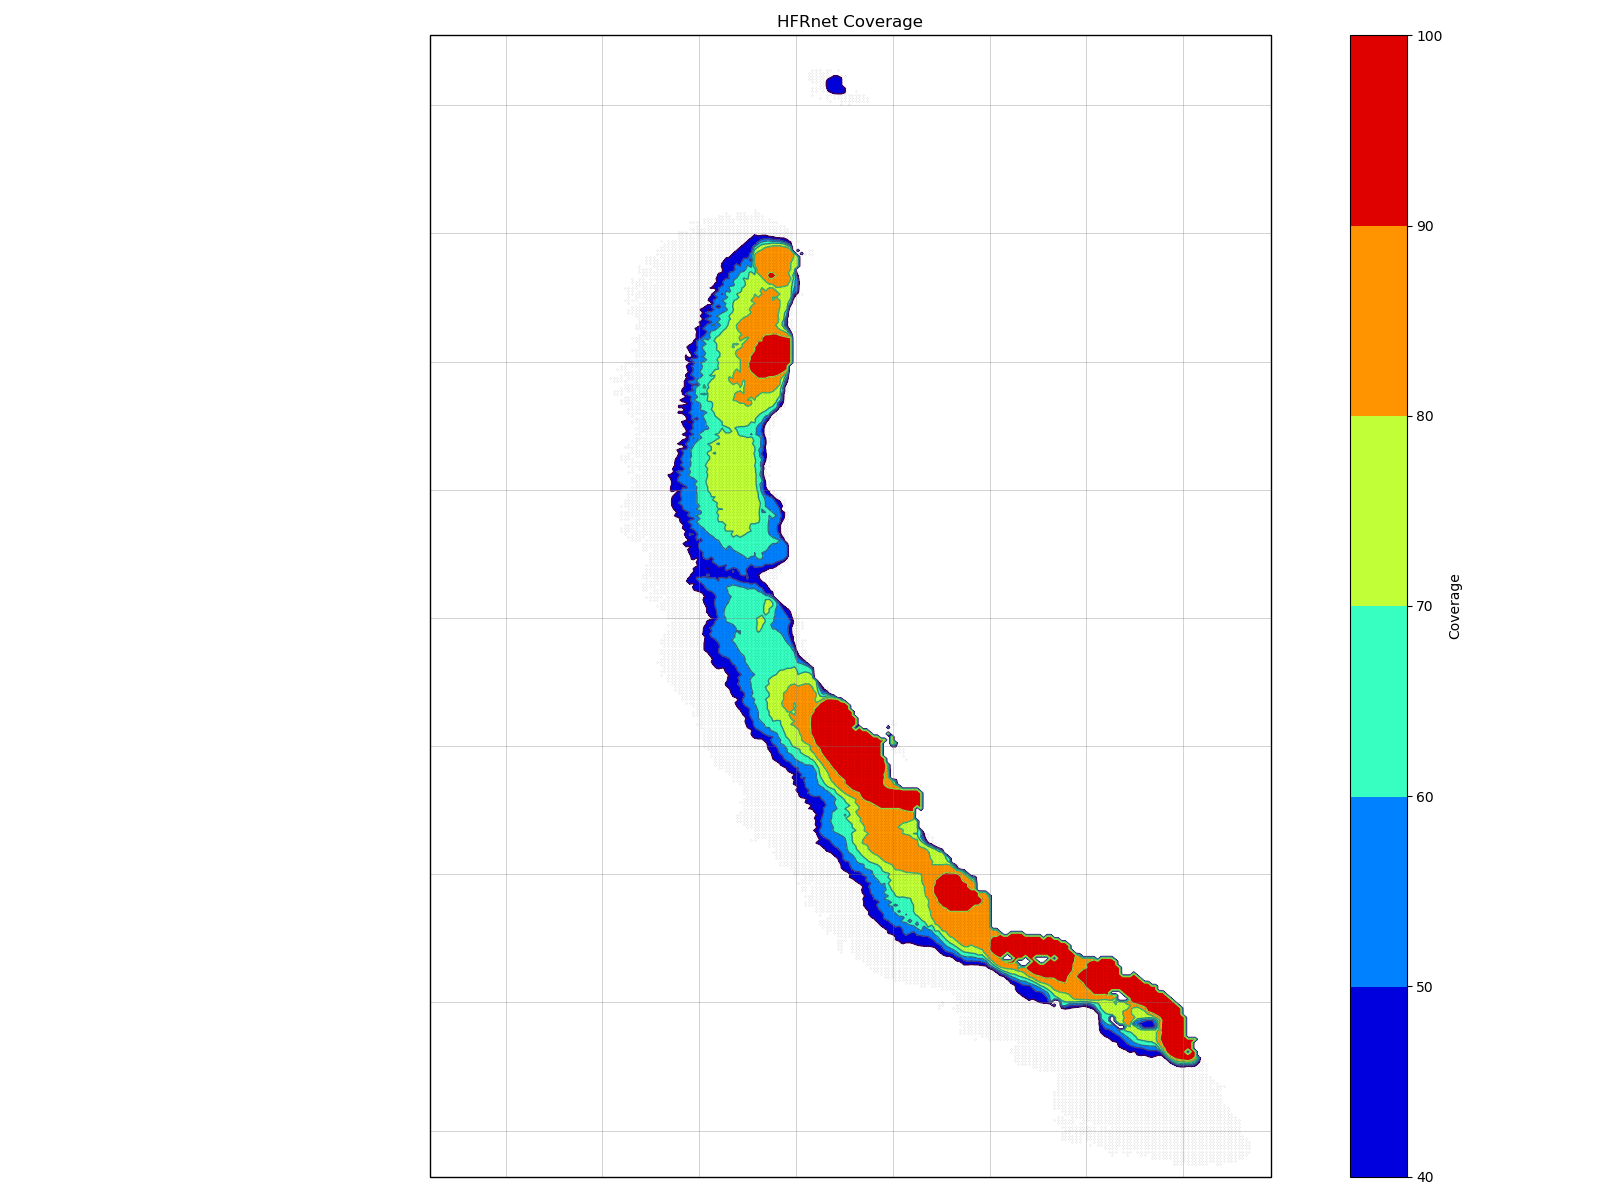

In [18]:
fig=plt.figure(figsize=(16,12))
#ax1=plt.axes(projection=crs.PlateCarree())
ax1=plt.axes(projection=crs.UTM(10))
ax1.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax1.set_title('HFRnet Coverage')
#ax1.set_extent([-167, -50, 15, 75])

CF=ax1.contourf(USWC_x,USWC_y,USWC_PC,[40,50,60,70,80,90,100],mask=USWC_mask,vmax=100,cmap='jet')
ax1.contour(USWC_x,USWC_y,USWC_PC,[40,50,60,70,80,90,100],mask=USWC_mask,linewidths=1)
ax1.plot(USWCgrid.lon,USWCgrid.lat,'.',markersize=.1,color='black')

ax1.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
plt.colorbar(CF,label="Coverage")
ax1.coastlines(resolution='10m',color='k')
plt.tight_layout()